In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import re, string, nltk
import pickle
from pymongo import MongoClient
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim import corpora, models, similarities, matutils
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import NMF, LatentDirichletAllocation

from time import time
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore

from wordcloud import WordCloud
from sklearn.feature_extraction import text
from os import path
from PIL import Image

Using TensorFlow backend.


In [2]:
def get_allcities_data():
    client = MongoClient(port=12345)
    db = client.jobs

    all_cities = pd.DataFrame()
    for city in db.collection_names():
        city_df = pd.DataFrame(list(db[city].find()))
        city_df['search_location'] = city

        all_cities = pd.concat([all_cities, city_df])



    return all_cities

In [5]:
def lsa_clusters(series, n_components, n_clusters):
    my_stop_words = text.ENGLISH_STOP_WORDS.union(["experience", "skills", "resume", "apply", "eligibility", "career",
                                                   "skills", "jobs", "location", "work"])

    tf = TfidfVectorizer(stop_words=my_stop_words, 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                        max_df=0.5,
                        min_df=10)
    tfidf_vecs = tf.fit_transform(series).toarray()

    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(tfidf_vecs)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

    km = KMeans(n_clusters=n_clusters)
    pred = km.fit_predict(X)    

    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]

    terms = tf.get_feature_names()
    
    for i in range(n_clusters):
        print("Cluster %d: " % i, end='')
        
        t = [terms[x] for x in order_centroids[i, :20]]
        wordcloud = WordCloud(background_color="white").generate(' '.join(t))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind], end='')
        print()
        

    return pred, terms, order_centroids

In [16]:
def cluster_cities(df, feature):
    
    
    pred, terms, order_centroids = lsa_clusters(df[feature], 300, 12)
    df[feature + '_cluster'] = pred
    
    df = df[df.search_location.isin(list(df.search_location.value_counts()[df.search_location.value_counts() > 1000].index))]
    
    print(df.search_location.unique())
    
    city_proportions = df.groupby('search_location')[feature + '_cluster'].value_counts(normalize=True).unstack(0).reset_index()
    city_proportions.fillna(0.0, inplace=True)
    city_proportions = city_proportions.transpose().drop(feature + '_cluster')
   
    km = KMeans(n_clusters=6)

    #print(city_proportions.columns)
    city_proportions['city_cluster'] = km.fit_predict(city_proportions)
    

    zs = city_proportions.apply(zscore)

    for i in range(12):
        s = zs[i]
        print(s[(s > 2.0) | (s < -2.0)])
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind], end='')
        
        plt.figure()
        city_proportions[i].plot(kind='bar')
        plt.xlabel('City')
        plt.ylabel('Percentage of jobs in cluster')
        plt.show()
        

    for i in city_proportions.city_cluster.unique():
        print(i)
        print(city_proportions[city_proportions.city_cluster == i].index)
        print()
        
    
    return city_proportions

In [3]:
df = get_allcities_data()


ServerSelectionTimeoutError: localhost:12345: [Errno 111] Connection refused

Performing dimensionality reduction using LSA
done in 113.602791s
Explained variance of the SVD step: 37%

Cluster 0: 

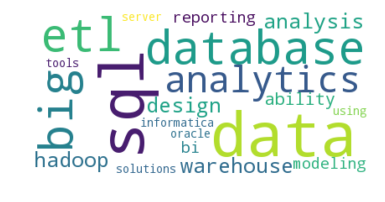

 data sql database etl big analytics analysis design hadoop warehouse ability reporting bi modeling solutions using tools server informatica oracle
Cluster 1: 

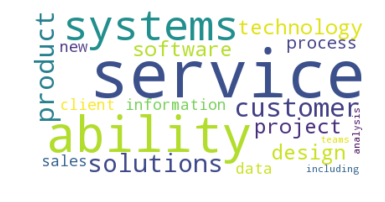

 ability systems customer product solutions technology design software project process information client sales new data service services including teams analysis
Cluster 2: 

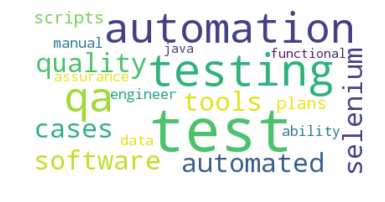

 test testing automation qa software quality automated cases selenium tools scripts plans engineer tests manual assurance ability data functional java
Cluster 3: 

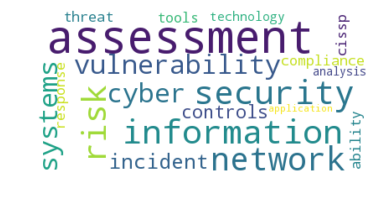

 security information network risk vulnerability systems cyber incident controls compliance response threat assessments cissp ability tools technology analysis assessment application
Cluster 4: 

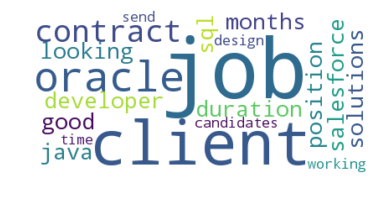

 com job client oracle contract developer looking position salesforce months solutions duration good java sql working design candidates time send
Cluster 5: 

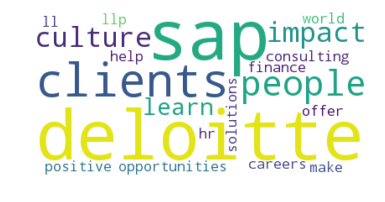

 deloitte sap clients people culture impact learn opportunities llp help careers consulting make world offer positive finance hr ll solutions
Cluster 6: 

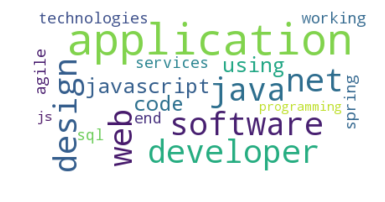

 web java software design net developer applications javascript application code using technologies sql services spring end agile working programming js
Cluster 7: 

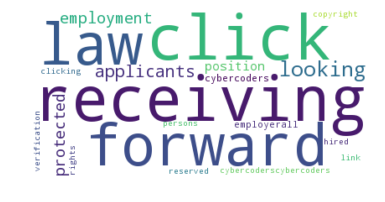

 receiving click forward law looking applicants employment protected position cybercoders employerall cybercoderscybercoders copyright reserved clicking hired persons rights verification link
Cluster 8: 

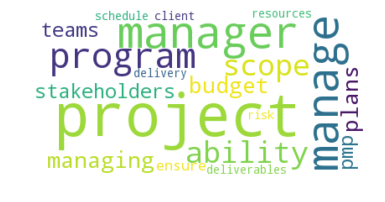

 project projects manager manage program ability scope managing budget plans stakeholders teams pmp ensure delivery schedule client deliverables resources risk
Cluster 9: 

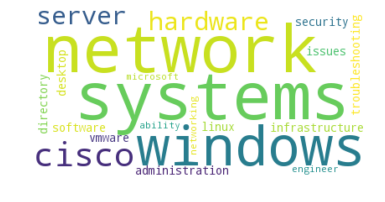

 network systems windows cisco hardware server infrastructure troubleshooting security software linux directory vmware administration desktop issues engineer ability microsoft networking
Cluster 10: 

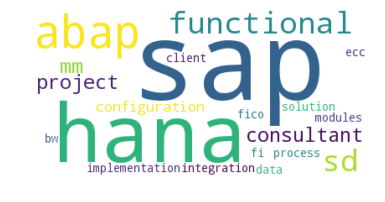

 sap hana abap functional sd consultant mm project configuration implementation data bw integration ecc fi solution process modules client fico
Cluster 11: 

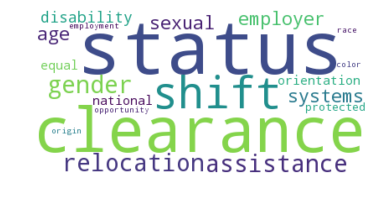

 status clearance shift gender relocation assistance employer systems age sexual disability orientation equal national protected opportunity employment race origin color
['Austin' 'Boston' 'Los Angeles' 'Philadelphia' 'Detroit' 'Charlotte'
 'Baltimore' 'Denver' 'Houston' 'Chicago' 'San Francisco' 'Dallas'
 'Phoenix' 'Seattle' 'New York' 'Atlanta' 'Washington DC']
search_location
Charlotte    2.600849
Name: 0, dtype: float64
 data sql database etl big analytics analysis design hadoop warehouse ability reporting bi modeling solutions using tools server informatica oracle

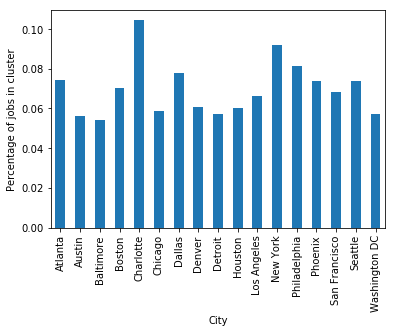

search_location
Los Angeles   -2.197889
Name: 1, dtype: float64
 ability systems customer product solutions technology design software project process information client sales new data service services including teams analysis

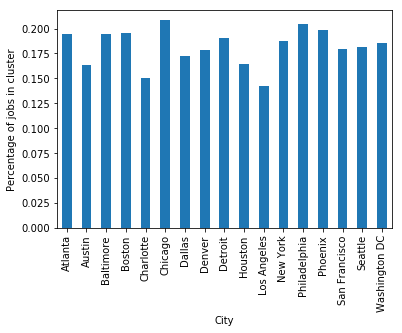

Series([], Name: 2, dtype: float64)
 test testing automation qa software quality automated cases selenium tools scripts plans engineer tests manual assurance ability data functional java

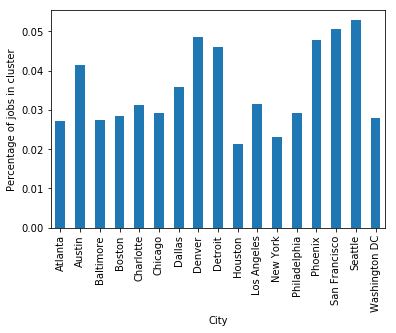

search_location
Baltimore        2.426328
Washington DC    2.354561
Name: 3, dtype: float64
 security information network risk vulnerability systems cyber incident controls compliance response threat assessments cissp ability tools technology analysis assessment application

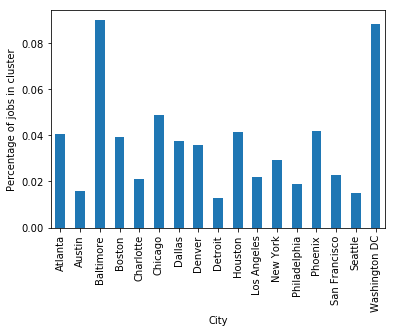

Series([], Name: 4, dtype: float64)
 com job client oracle contract developer looking position salesforce months solutions duration good java sql working design candidates time send

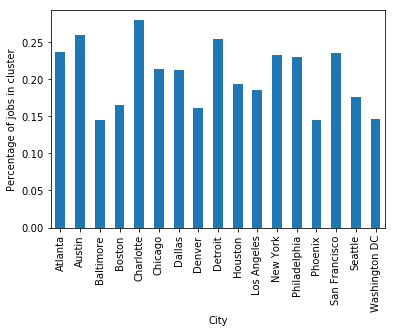

search_location
Houston    2.117166
Name: 5, dtype: float64
 deloitte sap clients people culture impact learn opportunities llp help careers consulting make world offer positive finance hr ll solutions

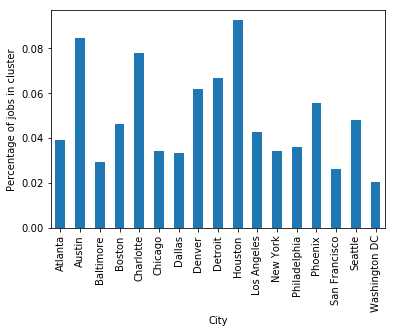

search_location
Dallas    2.129828
Name: 6, dtype: float64
 web java software design net developer applications javascript application code using technologies sql services spring end agile working programming js

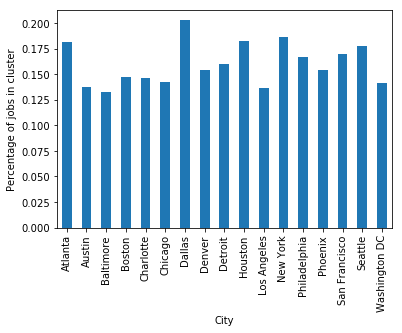

search_location
Los Angeles    2.718453
Name: 7, dtype: float64
 receiving click forward law looking applicants employment protected position cybercoders employerall cybercoderscybercoders copyright reserved clicking hired persons rights verification link

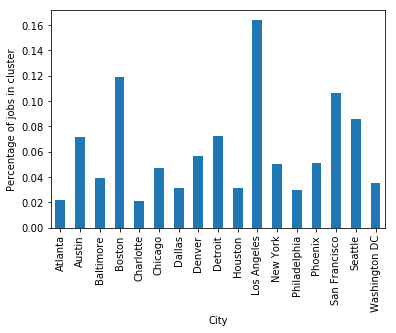

search_location
Philadelphia    2.150546
Name: 8, dtype: float64
 project projects manager manage program ability scope managing budget plans stakeholders teams pmp ensure delivery schedule client deliverables resources risk

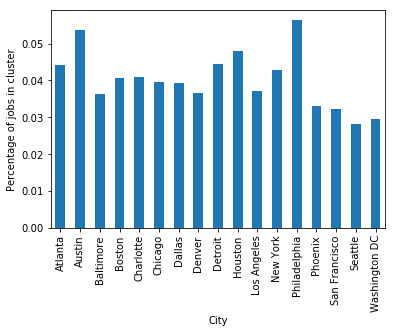

Series([], Name: 9, dtype: float64)
 network systems windows cisco hardware server infrastructure troubleshooting security software linux directory vmware administration desktop issues engineer ability microsoft networking

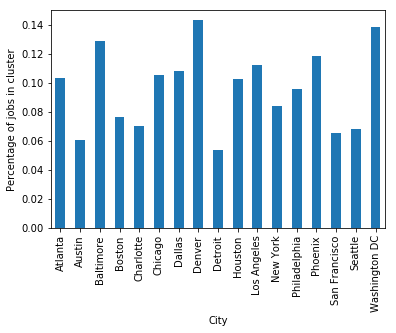

search_location
Houston    2.481506
Name: 10, dtype: float64
 sap hana abap functional sd consultant mm project configuration implementation data bw integration ecc fi solution process modules client fico

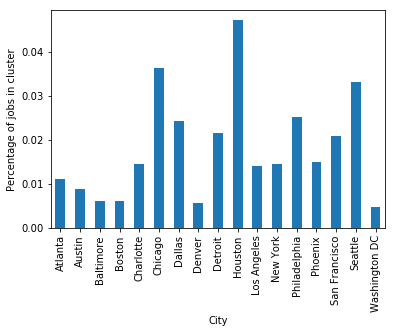

search_location
Baltimore        2.218958
Washington DC    2.449811
Name: 11, dtype: float64
 status clearance shift gender relocation assistance employer systems age sexual disability orientation equal national protected opportunity employment race origin color

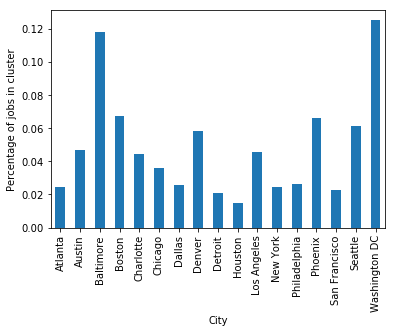

0
Index(['Atlanta', 'Chicago', 'Dallas', 'Houston', 'New York', 'Philadelphia'], dtype='object', name='search_location')

3
Index(['Austin', 'Charlotte', 'Detroit'], dtype='object', name='search_location')

2
Index(['Baltimore', 'Washington DC'], dtype='object', name='search_location')

1
Index(['Boston', 'San Francisco', 'Seattle'], dtype='object', name='search_location')

4
Index(['Denver', 'Phoenix'], dtype='object', name='search_location')

5
Index(['Los Angeles'], dtype='object', name='search_location')



,0,1,2,3,4,5,6,7,8,9,10,11,city_cluster
search_location,,,,,,,,,,,,,
Atlanta,0.074399,0.194582,0.027089,0.040824,0.237314,0.038916,0.181992,0.022129,0.044258,0.103014,0.011064,0.024418,0
Austin,0.056288,0.163588,0.041337,0.015831,0.260334,0.084433,0.137203,0.071240,0.053650,0.060686,0.008795,0.046614,3
Baltimore,0.053996,0.194339,0.027355,0.089914,0.144386,0.029258,0.132969,0.039010,0.036394,0.128687,0.005947,0.117745,2
Boston,0.070331,0.195156,0.028412,0.039124,0.164881,0.046111,0.147182,0.119236,0.040522,0.075920,0.006055,0.067070,1
Charlotte,0.104334,0.150080,0.031300,0.020867,0.279294,0.077849,0.146067,0.020867,0.040931,0.069823,0.014446,0.044141,3
Chicago,0.058913,0.208181,0.029304,0.048840,0.213980,0.034188,0.142857,0.047009,0.039683,0.105006,0.036325,0.035714,0
Dallas,0.077722,0.172864,0.035846,0.037521,0.212060,0.033166,0.202680,0.031156,0.039196,0.108208,0.024121,0.025461,0
Denver,0.060521,0.178044,0.048557,0.035890,0.161154,0.061928,0.154117,0.056298,0.036594,0.142857,0.005630,0.058410,4
Detroit,0.057383,0.190513,0.045907,0.013007,0.254017,0.066565,0.159908,0.072686,0.044376,0.053558,0.021423,0.020658,3


In [17]:
cluster_cities(df, 'description')

In [35]:
df.columns

Index(['_id', 'company', 'date', 'description', 'location', 'search_location',
       'title', 'url', 'description_cluster'],
      dtype='object')

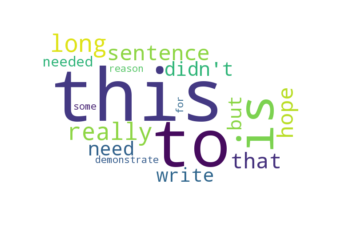

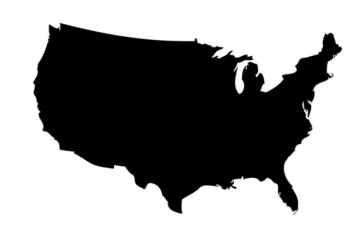

In [41]:
from os import path
from PIL import Image
alice_mask = np.array(Image.open("us.jpg"))



wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask, stopwords='english')
wc.generate("this is a really long sentence that I hope I didn't need to write but I needed to demonstrate this for some reason")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
df.search_location.value_counts()

New York         8102
San Francisco    6276
Washington DC    6147
Baltimore        4204
Los Angeles      3631
Chicago          3276
Dallas           2985
Atlanta          2621
Philadelphia     2577
Boston           2147
Seattle          1819
Denver           1421
Detroit          1307
Charlotte        1246
Phoenix          1149
Austin           1137
Houston          1083
San Diego         915
Raleigh           869
Miami             756
Portland          711
Pittsburgh        548
Orlando           545
Nashville         515
Sacramento        485
Kansas City       452
Cleveland         432
Madison           414
Las Vegas         209
Buffalo           125
New Orleans        89
Boise              61
Name: search_location, dtype: int64

In [25]:
df.shape

(58254, 9)